In [4]:
# album_blur.ipynb
# Created 8-25-19 by Eric Graves
# See spotify_album_blur.md for more information

In [28]:
# Imports and environment setup
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
import math
import scipy
import scipy.cluster
import scipy.misc
import binascii
%matplotlib inline

# DEBUG shows input and output images, DEBUG_VERBOSE shows images and sizes at each step
DEBUG = True

# This parameter sets how much the image is scaled before processing: 
#-- Smaller image ==> more loss, but faster processing
#-- Just divides the image dimensions in pixels, good values are between 1 and 10. Any smaller and there is a lot of loss of detail/accent colors.
IMAGE_SCALE = 15 
    
# The number of clusters for k-means image color processing
NUM_CLUSTERS = 5
    
# Single test image name
TEST_IMAGE = 'IMG_3725_ART.PNG'# Brockhampton Saturation III album art 

In [29]:
from pathlib import Path # used for path conversion in getting images for testing
import os

# Look for album art images in the directory: they all end with 'ART.PNG'
#-- Add found images to a list for later use
pngs = []

for root, dirs, files in os.walk(u"."):
    path = root.split(os.sep)
    
    for file in files:
        if file.endswith('ART.PNG'): 
            found_path =  str(os.path.realpath(root)) + "/" +  str(file)
            pngs.append(Path(found_path))

print("Found " + str(len(pngs)) + " images.")

Found 8 images.


Processing IMG_3723_ART.PNG with dimensions  (594, 592, 4)


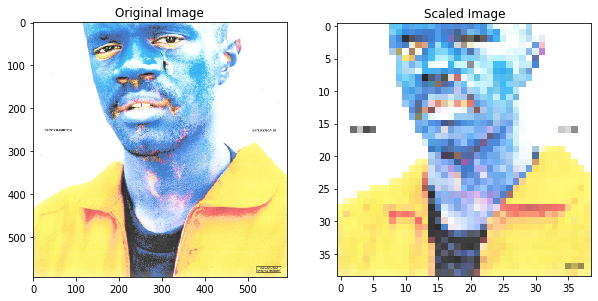

Max color: #fbfcfd
Accent color: #f37c92


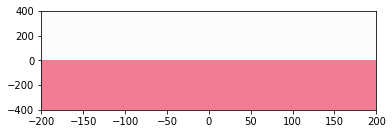

Processing IMG_3728_ART.PNG with dimensions  (592, 594, 4)


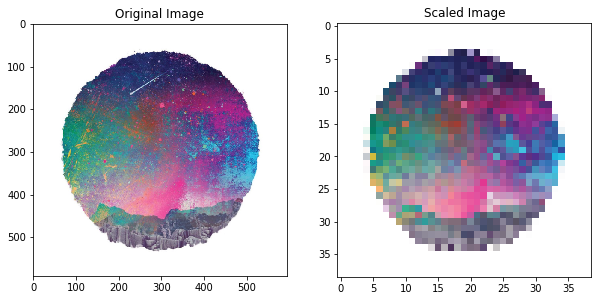

Max color: #fefefe
Accent color: #a57cff


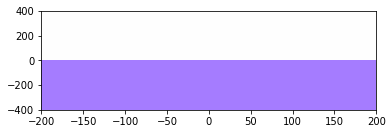

Processing IMG_3729_ART.PNG with dimensions  (594, 596, 4)


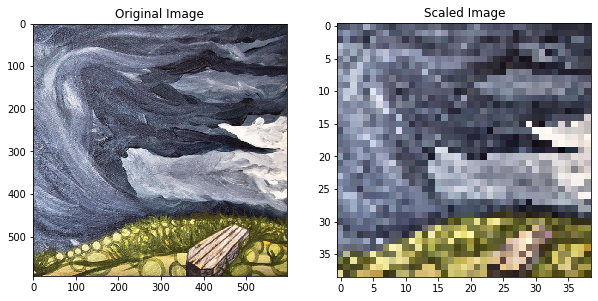

Max color: #555a6e
Accent color: #304712


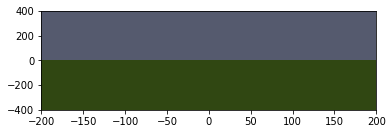

Processing IMG_3730_ART.PNG with dimensions  (593, 598, 4)


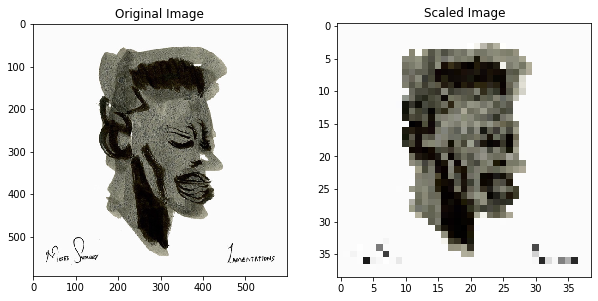

Max color: #fafafa
Accent color: #fb7dfb


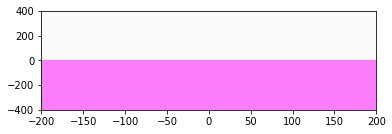

Processing IMG_3725_ART.PNG with dimensions  (591, 590, 4)


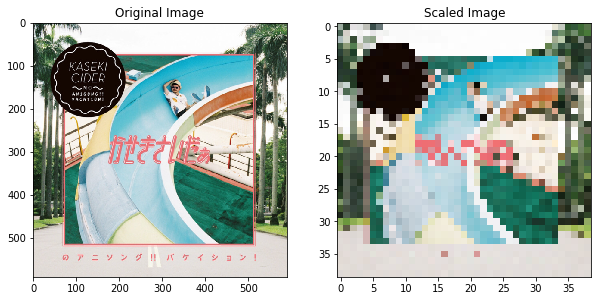

Max color: #e2e3e0
Accent color: #7b9a9e


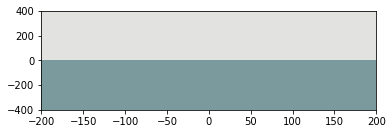

Processing IMG_3724_ART.PNG with dimensions  (593, 591, 4)


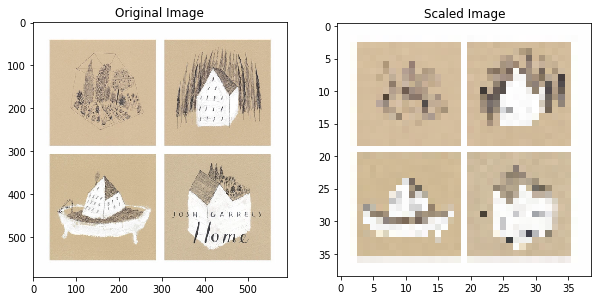

Max color: #d1bc9d
Accent color: #fefefe


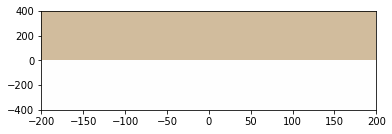

Processing IMG_3726_ART.PNG with dimensions  (593, 595, 4)


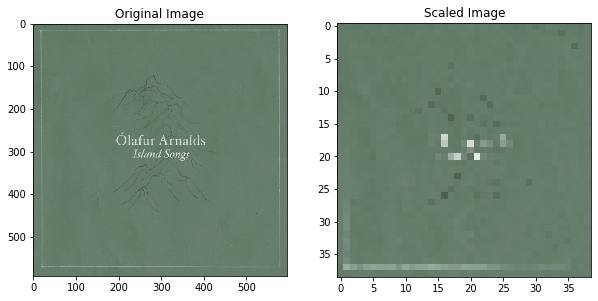

Max color: #647d6a
Accent color: #646166


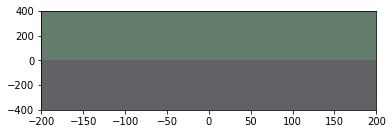

Processing IMG_3727_ART.PNG with dimensions  (592, 594, 4)


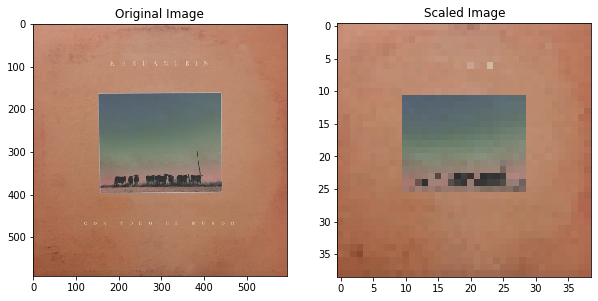

Max color: #b47c60
Accent color: #538774


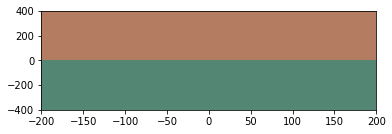

In [30]:
# Process found images
for image_path in pngs:
  
    # Read image, set size
    img = plt.imread(image_path, 0)
    img_PIL = Image.open(image_path) 
    h,w = img.shape[:2]
    
    print("Processing " + str(os.path.basename(image_path)) + " with dimensions ", img.shape)

    # Resize the image for faster processing time
    #-- there is noticable loss of color detail in thin lines on the artwork, as expected, but in order to save the accent colors scaling must be minimized.
    img_resized = img_PIL.resize(((int)(h/IMAGE_SCALE), (int)(w/IMAGE_SCALE)))
    
    # Show the original and scaled images
    if DEBUG:
        fig = plt.figure(figsize = (10,20))
        p_orig = fig.add_subplot(2,2,1)
        p_orig.set_title("Original Image")
        plt.imshow(img) 
        p_scaled = fig.add_subplot(2,2,2)
        p_scaled.set_title("Scaled Image")
        plt.imshow(img_resized) 
        plt.show()

    # Open PIL Image as array for cluster processing
    # Code modified from: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    img_as_array = np.asarray(img_resized)

    shape = img_as_array.shape # reshape to 2 dims
    img_as_array = img_as_array.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

    codes, dist = scipy.cluster.vq.kmeans(img_as_array, NUM_CLUSTERS)

    vecs, dist = scipy.cluster.vq.vq(img_as_array, codes)         # assign codes
    counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

    index_max = scipy.argmax(counts)                    # find most frequent
    peak = codes[index_max]

    index_sec = np.partition(img_as_array.flatten(), -2)       # find 2nd most frequent

    color_max = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
    color_max_cut = color_max[0:6] # cut off all the junk at the end. TODO: fix this later
    color_max_cut = '#' + color_max_cut
    print('Max color:', color_max_cut)

    color_sec = binascii.hexlify(bytearray(int(c) for c in index_sec)).decode('ascii')
    #print('second is %s (#%s)' % (index_sec, color_sec))
    color_sec_cut = color_sec[0:6] # cut off all the junk at the end. TODO: fix this later
    color_sec_cut = '#' + color_sec_cut
    print('Accent color:', color_sec_cut)

    # Display most frequent color (we dont usually want this one, since Spotify uses the accent color)
    fig = plt.figure()
    ax = fig.add_subplot(211)
    rect1 = matplotlib.patches.Rectangle((-200,0), 400, 400, color=color_max_cut)
    rect2 = matplotlib.patches.Rectangle((-200,-400), 400, 400, color=color_sec_cut)
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    plt.xlim([-200, 200])
    plt.ylim([-400, 400])
    plt.show()

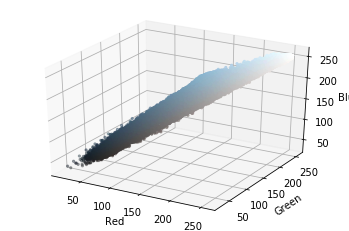

In [3]:
# Visualize image color components 
#-- Only use with single test image
#-- Computationally intensive compared to other code in the notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

vis_img = cv.imread(TEST_IMAGE) # Change to test different images

r, g, b = cv.split(vis_img)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = vis_img.reshape((np.shape(vis_img)[0]*np.shape(vis_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()